# fBM Simulation

### In this notebook, we simulate the process $\int_0^t (t-s)^{H-1/2}dW_s$

# 1. Cholesky approach (Exact)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special
def fBm_path_chol(grid_points, M, H, T):
    """
    @grid_points: # points in the simulation grid
    @H: Hurst Index
    @T: time horizon
    @M: # paths to simulate
    """
    
    assert 0<H<1.0
    
    ## Step1: create partition 
    
    X=np.linspace(0, 1, num=grid_points)
    
    # get rid of starting point
    X=X[1:grid_points]
    
    ## Step 2: compute covariance matrix
    Sigma=np.zeros((grid_points-1,grid_points-1))
    for j in range(grid_points-1):
        for i in range(grid_points-1):
            if i==j:
                Sigma[i,j]=np.power(X[i],2*H)/2/H
            else:
                s=np.minimum(X[i],X[j])
                t=np.maximum(X[i],X[j])
                Sigma[i,j]=np.power(t-s,H-0.5)/(H+0.5)*np.power(s,0.5+H)*special.hyp2f1(0.5-H, 0.5+H, 1.5+H, -s/(t-s))
        
    ## Step 3: compute Cholesky decomposition
    
    P=np.linalg.cholesky(Sigma)
    
    ## Step 4: draw Gaussian rv
    
    Z=np.random.normal(loc=0.0, scale=1.0, size=[M,grid_points-1])
    
    ## Step 5: get V
    
    W=np.zeros((M,grid_points))
    for i in range(M):
        W[i,1:grid_points]=np.dot(P,Z[i,:])
        
    #Use self-similarity to extend to [0,T] 
    
    return W*np.power(T,H)

C:\Users\localadmin\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


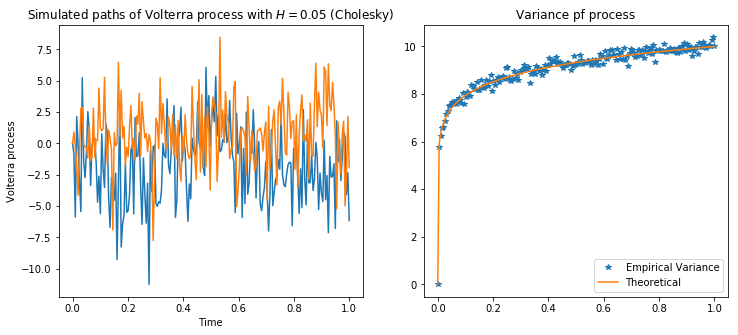

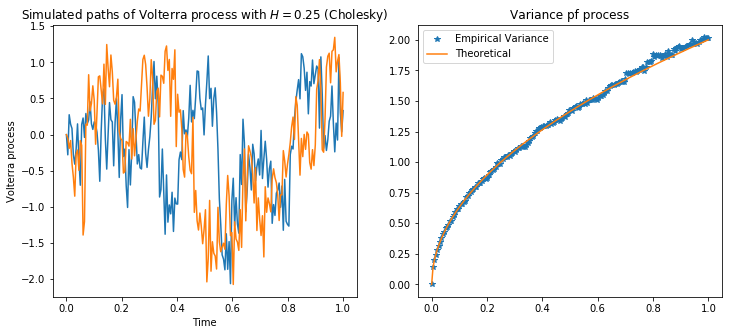

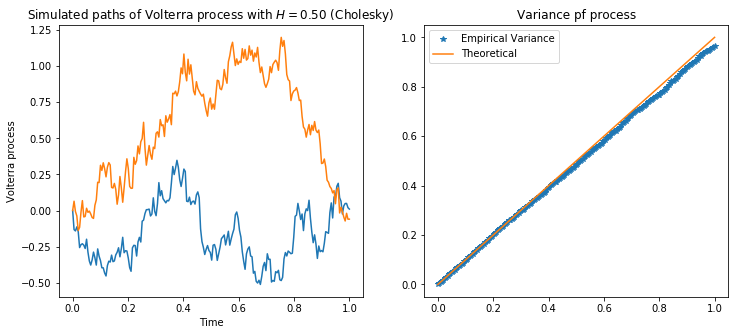

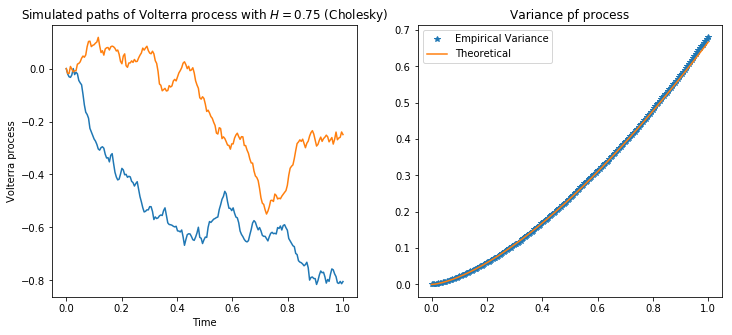

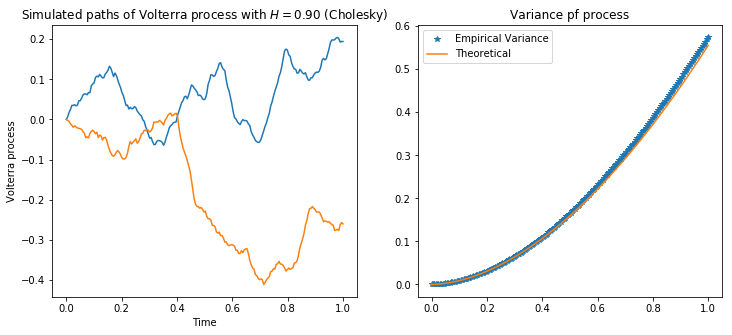

In [19]:
T=1
n=200
M=5000

Hs = [0.05,0.25,0.5,0.75,0.9]

times=np.linspace(0,T,n)

for H in Hs:
    
    path=fBm_path_chol(n, M, H, T)
    plt.subplots(figsize=(12, 5))
    for i in range(2):
        plt.subplot(1,2,1)
        plt.plot(times,path[i,:])
        
        
    plt.xlabel('Time')
    plt.ylabel('Volterra process')
    plt.title('Simulated paths of Volterra process with $H=%1.2f$ (Cholesky)'%H)
    plt.subplot(1,2,2)
    plt.title('Variance pf process')
    plt.plot(times,np.var(path,axis=0),'*',label="Empirical Variance")
    plt.plot(times,np.power(times,2*H)/2/H,label="Theoretical")
    plt.legend()
    plt.show()

# 2. rDonsker approach (Approximation)

In [20]:
def fBm_path_rDonsker(grid_points, M, H, T, kernel="optimal"):
    """
    @grid_points: # points in the simulation grid
    @H: Hurst Index
    @T: time horizon
    @M: # paths to simulate
    @kernel: kernel evaluation point use "optimal" for momen-match or "naive" for left-point
    """
    
    assert 0<H<1.0
    
    ## Step1: create partition 
    dt=1./(grid_points-1)
    X=np.linspace(0, 1, num=grid_points)
    
    # get rid of starting point
    X=X[1:grid_points]
    
    ## Step 2: Draw random variables
    
    dW = np.power(dt, H) *np.random.normal(loc=0, scale=1, size=[M, grid_points-1])
        
    ## Step 3: compute the kernel evaluation points
    i=np.arange(grid_points-1) + 1
    # By default use optimal moment-matching
    if kernel=="optimal":
        opt_k=np.power((np.power(i,2*H)-np.power(i-1.,2*H))/2.0/H,0.5)
    # Alternatively use left-point evaluation
    elif kernel=="naive" : 
        opt_k=np.power(i,H-0.5)
    else:
        raise NameError("That was not a valid kernel")
    
    
    ## Step 4: Compute the convolution
    
    Y = np.zeros([M, n])
    for i in range(int(M)):
        Y[i, 1:n] = np.convolve(opt_k, dW[i, :])[0:n - 1]
        
    #Use self-similarity to extend to [0,T] 
    
    return Y*np.power(T,H)

# 2.1 left-point evaluation (Naive forward euler simulation)

C:\Users\localadmin\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


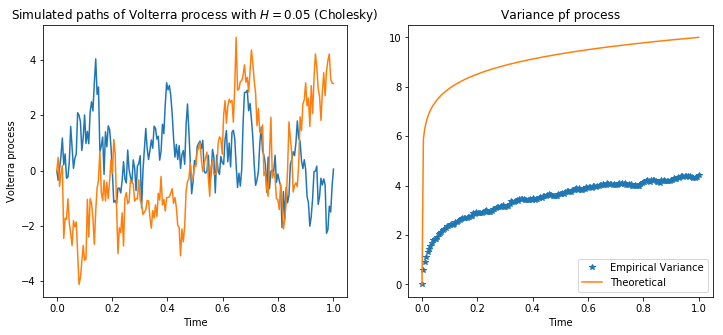

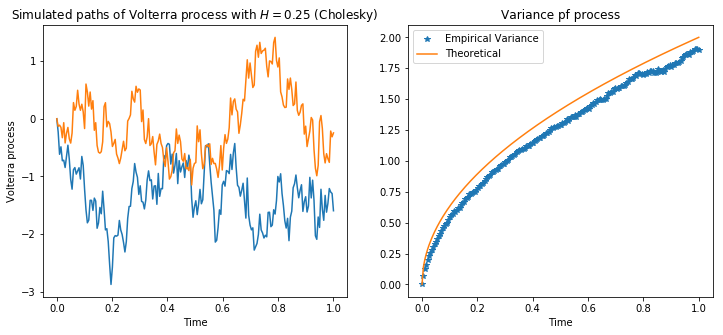

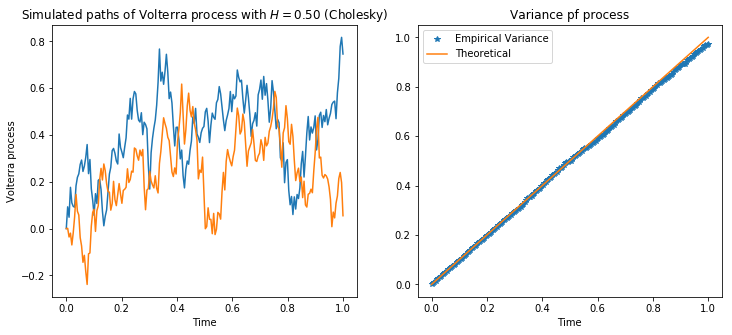

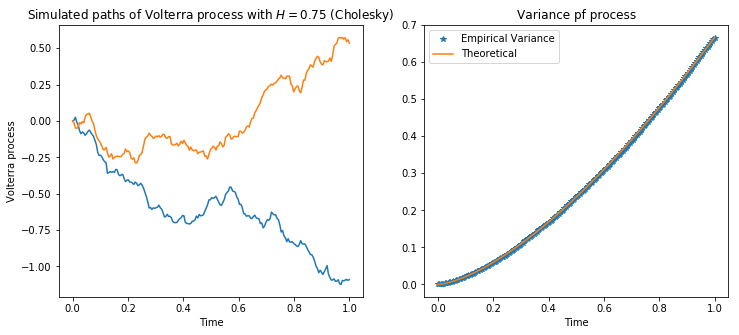

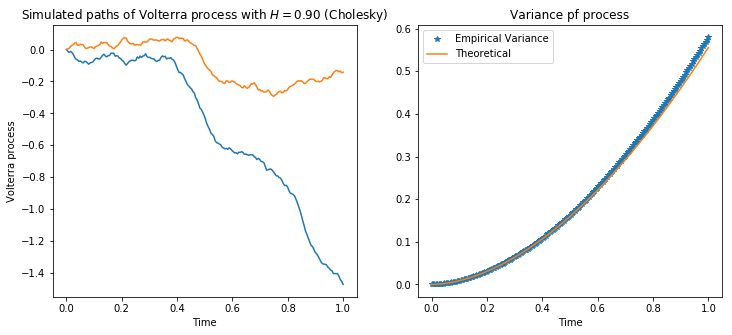

In [25]:
T=1
n=200
M=5000

Hs = [0.05,0.25,0.5,0.75,0.9]

times=np.linspace(0,T,n)

for H in Hs:
    
    path=fBm_path_rDonsker(n, M, H, T,kernel="naive")
    plt.subplots(figsize=(12, 5))
    for i in range(2):
        plt.subplot(1,2,1)
        plt.plot(times,path[i,:])
        
        
    plt.xlabel('Time')
    plt.ylabel('Volterra process')
    plt.title('Simulated paths of Volterra process with $H=%1.2f$ (Left-Point Euler)'%H)
    plt.subplot(1,2,2)
    plt.title('Variance pf process')
    plt.xlabel('Time')
    plt.plot(times,np.var(path,axis=0),'*',label="Empirical Variance")
    plt.plot(times,np.power(times,2*H)/2/H,label="Theoretical")
    plt.legend()
    plt.show()
        

### Specially, for small $H$ the left-point converges too slowly. This can be clearly seen in the roughness of the sample paths plots for $H=0.05$, when compared with the previous method.

# 2.2 Kernel evaluation using moment match

Then, equating the theoretical and approximating quantities we obtain
$\frac{1}{n}g(t^*_k)^2 d s=\int_{t_{k-1}}^{t_{k}} g(t-s)^2 d s$
for $k=1,\ldots,n$.
Finally, the optimal evaluation point can be computed as
\begin{equation}
g(t_k^*)=\sqrt{n\int_{t_{k-1}}^{t_{k}} g(t-s)^2 ds},
\qquad \text{for any }k=1,\ldots,n.
\end{equation}
In the Riemann-Liouville fractional Brownian motion case, 
$g(u) = u^{H-1/2}$, so that the optimal point can be computed in closed form as
$$
t_k^* = \left(\frac{n}{2H}\left[\left(t-t_{k-1}\right)^{2H}-\left(t-t_{k}\right)^{2H}\right]\right)^{1/(2H-1)},
\qquad \text{for each }k=1,\ldots,n.
$$


C:\Users\localadmin\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


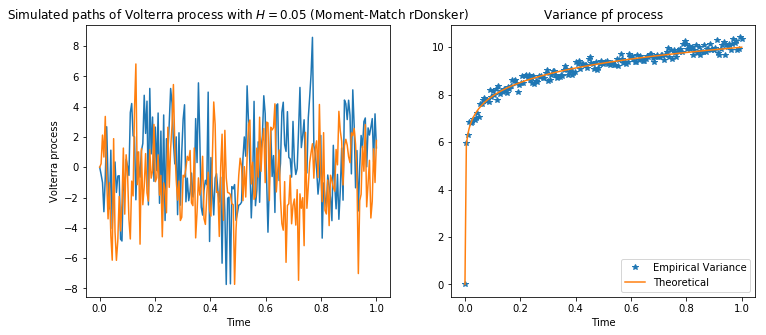

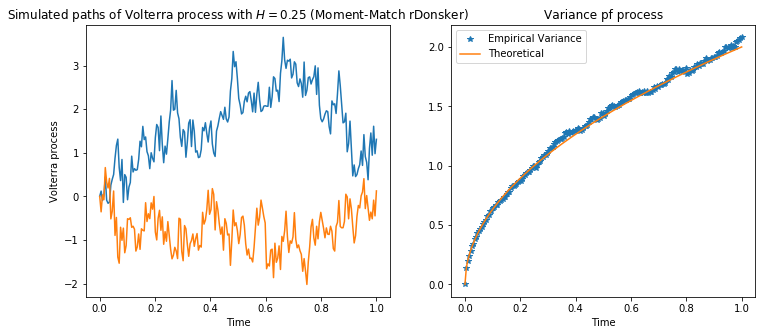

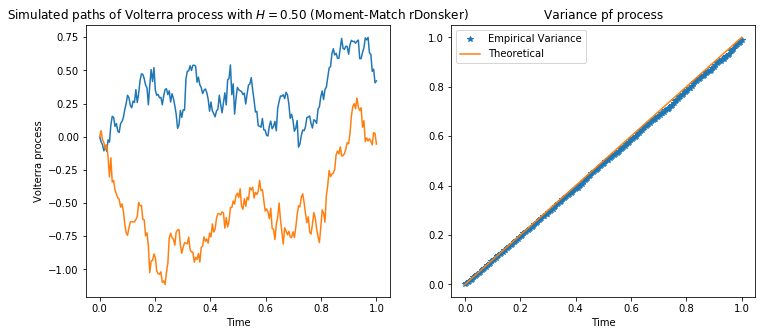

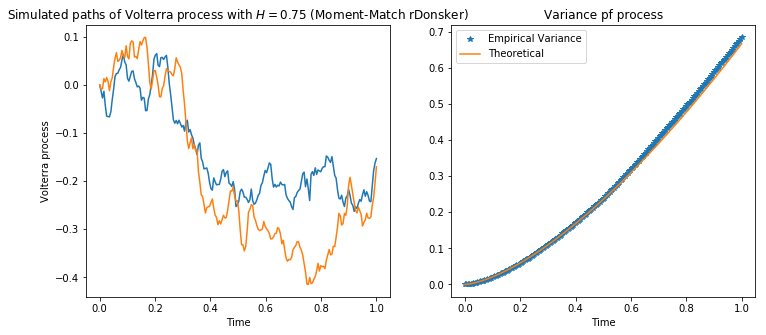

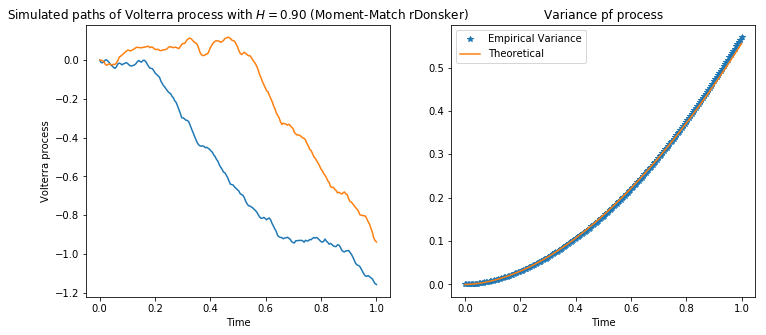

In [27]:
T=1
n=200
M=5000

Hs = [0.05,0.25,0.5,0.75,0.9]

times=np.linspace(0,T,n)

for H in Hs:
    
    path=fBm_path_rDonsker(n, M, H, T)
    
    plt.subplots(figsize=(12, 5))
    for i in range(2):
        plt.subplot(1,2,1)
        plt.plot(times,path[i,:])
        
        
    plt.xlabel('Time')
    plt.ylabel('Volterra process')
    plt.title('Simulated paths of Volterra process with $H=%1.2f$ (Moment-Match rDonsker)'%H)
    plt.subplot(1,2,2)
    plt.title('Variance pf process')
    plt.xlabel('Time')
    plt.plot(times,np.var(path,axis=0),'*',label="Empirical Variance")
    plt.plot(times,np.power(times,2*H)/2/H,label="Theoretical")
    plt.legend()
    plt.show()
        

# 3.Performance

In [39]:
M=5000
T=1
n=500

%timeit fBm_path_rDonsker(n, M, H, T, kernel="optimal")
%timeit fBm_path_chol(n, M, H, T)
%timeit np.cumsum(np.random.normal(0,np.sqrt(1/(n-1)),[M,n-1]),axis=1)

438 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.8 s ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
89 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Speed gain is remarkable, one can easily parallelize

## Only 5x slower than BM with simple implementation